<h2>Imports and Globals</h2>

In [2]:
%matplotlib inline

In [3]:
from __future__ import absolute_import
import os
import random
import re

from scipy.stats import chisquare
from sklearn import linear_model, preprocessing
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

DATA_DIR = '/Users/emiwang/Learning/notebooks/medpred/data/'
BASE_FILE = 'meps_base_data.csv'
MEDS_FILE = 'meps_meds.csv'

plt.style.use('ggplot')

<h2>Functions</h2>

<h2>Exploring the datasets</h2>

In [4]:
base_data = pd.read_csv(os.path.join(DATA_DIR, BASE_FILE))
meds_data = pd.read_csv(os.path.join(DATA_DIR, MEDS_FILE))

<h3>Base data</h3>

In [5]:
# There are ages of -1?  No data?  What is pooledWeight and what are the units?
base_data[['panel', 'pooledWeight', 'age']].describe()

,panel,pooledWeight,age
count,61489.000000,61489.000000,61489.000000
mean,13.534453,5063.701982,33.578396
std,1.061329,3815.885387,22.887576
min,12.000000,127.710358,-1.000000
25%,13.000000,2217.419038,14.000000
50%,14.000000,3989.180418,32.000000
75%,14.000000,6905.677619,51.000000
max,15.000000,38828.153564,85.000000


In [6]:
pd.get_dummies(base_data.panel)[:1]  # There are 4 panels; perhaps this data consists of 4 surveys.

,12,13,14,15
0,0.0,0.0,0.0,1.0


In [7]:
100 * float(base_data[base_data.age==-1].count().id) / len(base_data)  # 2.8% of entries have no valid age

2.777732602579323

In [8]:
len(base_data), len(base_data.drop_duplicates())  # No completely duplicate entries

(61489, 61489)

In [9]:
# Remove the unnamed index, id, and panel columns
subset_cols = [i for i in base_data.columns if i not in ('Unnamed: 0', 'id', 'panel')]
# Check for duplicates: less than 1% are duplicated
len(base_data), len(base_data.drop_duplicates(subset=subset_cols))

(61489, 61315)

In [10]:
subset_base_data = base_data.copy(deep=True)
subset_base_data = subset_base_data[subset_cols]
subset_base_data['entry_count'] = 1

In [11]:
dupe_count = subset_base_data.groupby(subset_cols).count()
# dupe_count[dupe_count.entry_count > 1].head()

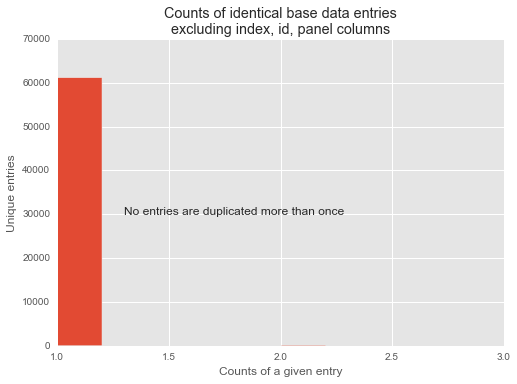

In [12]:
dupe_count.entry_count.hist(bins=10)
plt.title('Counts of identical base data entries\nexcluding index, id, panel columns')
plt.xlabel('Counts of a given entry')
plt.ylabel('Unique entries')
plt.text(1.3, 30000, 'No entries are duplicated more than once', fontsize=12)

In [13]:
base_data.head()  # If people are under 16 they can't be married?  Or question is omitted if patient under 16?

,Unnamed: 0,id,panel,pooledWeight,age,sex,race,married,highBPDiagnosed,diabetesDiagnosed,chdDiagnosed,miDiagnosed,anginaDiagnosed,strokeDiagnosed,emphysemaDiagnosed,asthmaDiagnosed,otherHDDiagnosed,heartFailureDiagnosed
0,1,10007101,15,3603.881236,28,Male,White,MARRIED,Yes,No,No,No,No,No,No,No,No,No
1,2,10007102,15,2544.550424,25,Female,White,MARRIED,No,No,No,No,No,No,No,Yes,No,No
2,3,10007103,15,4050.397468,4,Male,White,UNDER 16 - INAPPLICABLE,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,No,Inapplicable,No
3,4,10007104,15,3064.059720,3,Female,White,UNDER 16 - INAPPLICABLE,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,No,Inapplicable,No
4,5,10008101,15,3635.552466,51,Male,Multiple,MARRIED,No,No,No,No,No,No,No,No,No,No


In [14]:
base_copy = base_data.copy(deep=True)
base_copy = base_copy.drop('Unnamed: 0', 1)

In [15]:
# Looking at frequencies for categorical variables
base_copy['entry_count'] = 1
cat_cols = [i for i in base_data.columns if i not in ('Unnamed: 0', 'id', 'panel', 'age', 'pooledWeight')]
for column in cat_cols:
    print base_copy.groupby(column).count()[['entry_count']]

        entry_count
sex                
Female        32075
Male          29414
                                  entry_count
race                                         
Amer Indian/Alaska Native                 623
Asian                                    4080
Black                                   12325
Multiple                                 1358
Native Hawaiian/Pacific Islander          234
White                                   42869
                         entry_count
married                             
DIVORCED                        3196
DIVORCED IN ROUND               1238
INAPPLICABLE                    1708
MARRIED                        21424
MARRIED IN ROUND                1021
NEVER MARRIED                  13435
SEPARATED                        672
SEPARATED IN ROUND               615
UNDER 16 - INAPPLICABLE        15515
WIDOWED                         2294
WIDOWED IN ROUND                 371
                 entry_count
highBPDiagnosed             
DK           

<h3>Prescribed meds data</h3>

In [18]:
meds_data.describe()  # Missing start month and start year represented as negative numbers?

,Unnamed: 0,id,rxStartMonth,rxStartYear,rxNDC,rxQuantity
count,1.148347e+06,1.148347e+06,1.148347e+06,1.148347e+06,1.148347e+06,1.148347e+06
mean,1.240252e+06,5.523596e+07,5.184600e-01,1.172427e+03,2.226109e+10,5.942380e+01
std,9.590400e+05,2.728584e+07,4.087907e+00,9.895660e+02,2.834269e+10,3.702845e+02
min,1.000000e+00,1.000710e+07,-9.000000e+00,-1.400000e+01,-9.000000e+00,-9.000000e+00
25%,2.870875e+05,4.063810e+07,-1.000000e+00,-1.000000e+00,1.490472e+08,3.000000e+01
50%,1.093262e+06,4.947510e+07,-1.000000e+00,2.000000e+03,5.910385e+08,3.000000e+01
75%,2.103602e+06,8.118210e+07,1.000000e+00,2.008000e+03,5.486835e+10,6.800000e+01
max,3.336212e+06,8.968810e+07,1.200000e+01,2.011000e+03,9.920707e+10,1.200000e+05


In [19]:
meds_data.head()

,Unnamed: 0,id,rxStartMonth,rxStartYear,rxName,rxNDC,rxQuantity,rxForm
0,1,10007104,3,2011,AMOXICILLIN,143988775,75.0,SUSR
1,2,10007104,3,2011,OTIC EDGE SOLUTION,68032032814,14.0,SOL
2,3,10008102,3,2011,NASAL DECONGESTANT 0.05% SPRAY,63981056903,15.0,SPR
3,4,10008102,3,2011,NASAL DECONGESTANT 0.05% SPRAY,63981056903,15.0,SPR
4,5,10008102,9,2011,DIPHENHYDRAM,603333921,30.0,CAP


In [20]:
len(meds_data), len(meds_data.drop_duplicates())  # Also no completely duplicate rows here

(1148347, 1148347)

There are a lot of different rxNames.  Maybe some are named by chemical name and others are named by brand name.  And some could just be duped because of spacing or spelling.  How specific are these?  For instance, "Nasal Decongestant" seems rather vague.

In [21]:
len(meds_data.rxName.unique()), len(meds_data.rxNDC.unique()), len(meds_data.rxForm.unique())

(9218, 28736, 328)

A quick look at sorted names already reveals some obvious duplicates, e.g. ' HYDROCHLOROTHIAZIDE (HCTZ)' vs. ' HYDROCHLOROTHIZAIDE'.  That number in front of some meds seems like it is a category code.

In [22]:
sorted(list(meds_data.rxName.unique()))[0:20]

[' CLOPIDOGREL',
 ' HYDROCHLOROTHIAZIDE (HCTZ)',
 ' HYDROCHLOROTHIZAIDE',
 ' LIPITOR',
 '(ARMOUR) THYROID (1GR)',
 '-9',
 '1 ANTI-INFECTIVES',
 '1.5 INCH 27 GAUGE NEEDLE',
 '1/2ML TB SYR',
 '10',
 '105 MISCELLANEOUS AGENTS',
 '113 GENITOURINARY TRACT AGENTS',
 '115 NUTRITIONAL PRODUCTS',
 '122 RESPIRATORY AGENTS',
 '133 TOPICAL AGENTS',
 '1CC TB SYRNG27GX1/2"',
 '1ML TB SYRNG',
 '20 ANTINEOPLASTICS',
 '218 ALTERNATIVE MEDICINES',
 '242 PSYCHOTHERAPEUTIC AGENTS']

Looking at specific drug strings to understand the duping situation.  There are punctuation variations for drug combinations, so we should treat the &, AND, -, and / situations as equivalent.  Possibly eliminate things in parentheses, since they tend to be commentary on the form of the prescription.

In [23]:
zyp_set = set([i for i in meds_data.rxName if 'ZYPREXA' in i])
zyp_set

{'ZYPREXA',
 'ZYPREXA (IDENTI-DOSE)',
 'ZYPREXA 10MG',
 'ZYPREXA 15MG',
 'ZYPREXA ZYDI',
 'ZYPREXA ZYDIS',
 'ZYPREXA ZYDIS (DOSE PACK)'}

In [24]:
hctz_set = set([i for i in meds_data.rxName if 'HYDROCHLOROTHIAZIDE' in i])
hctz_set

{' HYDROCHLOROTHIAZIDE (HCTZ)',
 'AMILORIDE HCL-HYDROCHLOROTHIAZIDE',
 'BENAZEPRIL HCL/HYDROCHLOROTHIAZIDE',
 'BENAZEPRIL HCL/HYDROCHLOROTHIAZIDE (FILM-COATED)',
 'BENAZEPRIL-HYDROCHLOROTHIAZIDE',
 'BISOPROLOL & HYDROCHLOROTHIAZIDE',
 'BISOPROLOL-HYDROCHLOROTHIAZIDE',
 'CAPTOPRIL-HYDROCHLOROTHIAZIDE',
 'ENALAPRIL-HYDROCHLOROTHIAZIDE',
 'ENALPRIL/HYDROCHLOROTHIAZIDE',
 'FOSINOPRIL-HYDROCHLOROTHIAZIDE',
 'HYDROCHLOROTHIAZIDE',
 'HYDROCHLOROTHIAZIDE (HARD GELATIN)',
 'HYDROCHLOROTHIAZIDE (HCTZ)',
 'HYDROCHLOROTHIAZIDE (UNIT OF USE)',
 'HYDROCHLOROTHIAZIDE (USP)',
 'HYDROCHLOROTHIAZIDE 25 MG',
 'HYDROCHLOROTHIAZIDE 25 MG TABLET',
 'HYDROCHLOROTHIAZIDE-LISINOPRIL',
 'HYDROCHLOROTHIAZIDE-METOPROLOL',
 'HYDROCHLOROTHIAZIDE-MOEXIPRIL HYDROCHLORIDE',
 'HYDROCHLOROTHIAZIDE-PO 25MG TAB',
 'HYDROCHLOROTHIAZIDE-PROPRANOLOL',
 'HYDROCHLOROTHIAZIDE-QUINAPRIL HYDROCHLORIDE',
 'HYDROCHLOROTHIAZIDE-SPIRONOLACTONE',
 'HYDROCHLOROTHIAZIDE-TRIAMTERENE',
 'HYDROCHLOROTHIAZIDE/LISINOPRIL',
 'HYDROCHLOROTHIAZ

In [24]:
list(set([i for i in meds_data.rxName if 'HCTZ' in i]))[0:10]  # Abbreviations also cause duping.  Ignore for now.

['TRIAMT/HCTZ',
 'BISOPRL/HCTZ',
 'TRIMT/HCTZ',
 'ENALAPR/HCTZ',
 'MAXZIDE-25 <HCTZ/TRIAM>',
 'TRAIMTERENE/HCTZ',
 'LISINO-HCTZ',
 'LISINOP /HCTZ',
 'BISOPROLOL/HCTZ (10X10)',
 'LOSARTAN-HCTZ']

In [25]:
[i for i in meds_data.rxName if '<' in i or '>' in i][0:10]  # Brand names and chemical abbreviations

['VICODIN <HYDROCOD/APAP>',
 'VICODIN <HYDROCOD/APAP>',
 'VICODIN <HYDROCOD/APAP>',
 'VICODIN <HYDROCOD/APAP>',
 'VICODIN <HYDROCOD/APAP>',
 'VICODIN <HYDROCOD/APAP>',
 'MAXZIDE-25 <HCTZ/TRIAM>',
 'MAXZIDE-25 <HCTZ/TRIAM>']

In [26]:
# But sometimes the brand names don't include chemical names.  Ignore for now.
set([i for i in meds_data.rxName if 'VICODIN' in i])

{'VICODIN',
 'VICODIN 5 MG/500 MG',
 'VICODIN <HYDROCOD/APAP>',
 'VICODIN EQUIV',
 'VICODIN ES',
 'VICODIN ES (R.N.P.,4X25)',
 'VICODIN HP',
 'VICODIN TUSS EXPECTORANT (AF,SF,DYE-FREE,CHERRY)',
 'VICODIN/EQUIV'}

In [27]:
# HCL/Hydrochloride is a common name at the end of a salt: https://en.wikipedia.org/wiki/Hydrochloride
# Let's remove all trailing HCL and Hydrochloride
list(set([i for i in meds_data.rxName if 'HYDROCHLORIDE' in i or 'HCL' in i]))[0:10]

['DICYCLOMINE HCL (BERRY)',
 'DIPHENOXYLATE HCL',
 'AMLODIPINE BESYLATE-BENAZEPRIL HCL',
 'RANITIDINE HCL',
 'TRAZODONE HCL 100 MG TAB',
 'NEFAZODONE HYDROCHLORIDE',
 'ZIPRASIDONE HCL',
 'DOXEPIN HCL',
 'PILOCARPINE HCL',
 'DORZOLAMIDE HYDROCHLORIDE - TIMOLOL (1X10ML)']

In [28]:
def clean_rxname(rxname):
    """Make string substitutions to dedupe rxnames.
    
    Remove all parenthetical statements.
    Remove all statements after a comma.
    Remove HCL and HYDROCHLORIDE groups.
    Replace ' AND ', '/', ' & ' with '-'.
    Truncate trailing ' TABLET', ' TAB'.
    Strip trailing and leading spaces.

    """
    replacements = [
        ('\([\w\s\D]+\)', ''),
        (',[\w\s\D]+', ''),
        ('\([-,/\w^\)]+\Z',''),  
        (' HCL', ''),
        (' HYDROCHLORIDE', ''),
        (' AND ', '-'),
        (' & ', '-'),
        ('/', '-'),
        (' TABLET\Z', ''),
        (' TAB\Z', '')
    ]
    for pattern in replacements:
        rxname = re.sub(pattern[0], pattern[1], rxname)
    rxname = rxname.rstrip().lstrip()
    return rxname

In [29]:
re.sub('\([-,/\w^\)]+\Z','','ab (bb,woo/hoo,lee-t')  # This works for everything except trailing whitespace

'ab '

In [30]:
# Won't get rid of everything if there is close parens;
# that will be eliminated by our open/close paren matching pattern.
re.sub('\([-,/\w^\)]+\Z','','ab (bb,woo/hoo,lee-t) eh')  

'ab (bb,woo/hoo,lee-t) eh'

In [31]:
clean_rxname(' HYDROCHLOROTHIAZIDE AND MEEP & RAINBOW/CHARMS (FILM-COATED 22 MG)')

'HYDROCHLOROTHIAZIDE-MEEP-RAINBOW-CHARMS'

In [32]:
hctz_clean = [clean_rxname(i) for i in hctz_set]
set(hctz_clean)

{'AMILORIDE-HYDROCHLOROTHIAZIDE',
 'BENAZEPRIL-HYDROCHLOROTHIAZIDE',
 'BISOPROLOL-HYDROCHLOROTHIAZIDE',
 'CAPTOPRIL-HYDROCHLOROTHIAZIDE',
 'ENALAPRIL-HYDROCHLOROTHIAZIDE',
 'ENALPRIL-HYDROCHLOROTHIAZIDE',
 'FOSINOPRIL-HYDROCHLOROTHIAZIDE',
 'HYDROCHLOROTHIAZIDE',
 'HYDROCHLOROTHIAZIDE 25 MG',
 'HYDROCHLOROTHIAZIDE-LISINOPRIL',
 'HYDROCHLOROTHIAZIDE-METOPROLOL',
 'HYDROCHLOROTHIAZIDE-MOEXIPRIL',
 'HYDROCHLOROTHIAZIDE-PO 25MG',
 'HYDROCHLOROTHIAZIDE-PROPRANOLOL',
 'HYDROCHLOROTHIAZIDE-QUINAPRIL',
 'HYDROCHLOROTHIAZIDE-SPIRONOLACTONE',
 'HYDROCHLOROTHIAZIDE-TRIAMTERENE',
 'LISINOPRIL-HYDROCHLOROTHIAZIDE',
 'LOSARTAN POTASSIUM-HYDROCHLOROTHIAZIDE',
 'QUINAPRIL-HYDROCHLOROTHIAZIDE',
 'SPIRONOLACTONE-HYDROCHLOROTHIAZIDE',
 'TRIAMTERENE-HYDROCHLOROTHIAZIDE',
 'VALSARTAN-HYDROCHLOROTHIAZIDE'}

In [33]:
meds_copy = meds_data.copy(deep=True)
meds_copy = meds_copy.drop('Unnamed: 0', 1)

In [34]:
rxnames = meds_copy.rxName
rxnames_clean = [clean_rxname(i) for i in rxnames]

In [35]:
len(set(rxnames_clean)), len(rxnames)  # Much reduction in number of unique rxnames!

(7345, 1148347)

In [37]:
len(rxnames_clean), len(rxnames)  # nothing weird happened and we still have the same number of rxnames

(1148347, 1148347)

In [38]:
meds_copy['rxName'] = rxnames_clean

In [41]:
meds_copy.head()  # Note there are duped id rxName pairs that we will have to dedupe later.

,id,rxStartMonth,rxStartYear,rxName,rxNDC,rxQuantity,rxForm
0,10007104,3,2011,AMOXICILLIN,143988775,75.0,SUSR
1,10007104,3,2011,OTIC EDGE SOLUTION,68032032814,14.0,SOL
2,10008102,3,2011,NASAL DECONGESTANT 0.05% SPRAY,63981056903,15.0,SPR
3,10008102,3,2011,NASAL DECONGESTANT 0.05% SPRAY,63981056903,15.0,SPR
4,10008102,9,2011,DIPHENHYDRAM,603333921,30.0,CAP


<h2>Initial questions</h2>

1. What are the most common medications for each disease in the base file?
2. What medications are most indicative of each disease?

Approach: For each disease where someone is diagnosed (Yes), make a histogram of the prescriptions associated.  Get the top 10 or so.

Some considerations:
    
- Diseases will be correlated, so we will need to take this into account.  We could try selecting only people diagnosed with one disease and see what meds they are taking.  However, some diseases might just be connected.  High blood pressure can apparently lead to diabetes:
http://www.webmd.com/hypertension-high-blood-pressure/guide/high-blood-pressure.  In this case, even if someone has a diagnosis for only diabetes, we could be missing diagnosis data for other diseases.  Or a doctor might prescribe corresponding medication just in case?

- People could have multuple Rx entries for the same drug.  We want to only count one per patient when getting frequencies.

- We have only done rudimentary deduping, related to string formatting and extra comments.  More deduping could be done if we had a repository of the multiple names different drugs can take.  Some quick googling reveals most drugs have generic and brand names.

- We could be more rigorous and do a categorical correlation test like Cramer's V or chi-square to look at correlations between medications and disease diagnoses.  Or reduce dimensionality using multiple correspondence analysis first.  But looking at the top 10 should be a good estimate.

In [299]:
base_cats = pd.get_dummies(base_copy)  # Make binary columns for all categories
yes_cols = [i for i in base_cats.columns if 'Yes' in i]  # Column for total yes diagnoses a patient has.

In [300]:
select_cols = ['id', 'entry_count'] + yes_cols
base_yes = base_cats[select_cols]
base_yes['total_yes'] = base_yes[yes_cols].sum(axis=1)

/Users/emiwang/.virtualenvs/testing/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [44]:
len(base_yes[base_yes.total_yes == 1])

12714

Only count one of any given rxName per patient id.

In [45]:
meds_one_per_patient = meds_copy.drop_duplicates(subset=['id','rxName'])

In [46]:
len(meds_copy), len(meds_one_per_patient)

(1148347, 231546)

In [47]:
merged_yes = pd.merge(base_yes, meds_one_per_patient, on='id', how='inner')

In [48]:
len(merged_yes), len(base_copy), len(meds_copy)

(231546, 61489, 1148347)

In [49]:
def get_disease_stats(df, disease='highBPDiagnosed_Yes', top_n=10,
                      return_df=False, print_stats=True, return_rxnames=False):
    """Return fraction of entries that have a given disease and a list of unique medication counts."""
    
    df_yes = df[df[disease] == 1]
    frac_yes = len(df_yes) / float(len(df))
    
    rxname_count = df_yes.groupby('rxName').count()[['entry_count']]
    rxname_count['percent'] = 100 * rxname_count.entry_count / float(rxname_count.entry_count.sum())
    rxname_top_ser = rxname_count.sort_values(by='entry_count', ascending=False)[0:top_n]
    
    if print_stats:
        print 'Stats for {}:'.format(disease)
        print '{:.2} of single yes entries.'.format(frac_yes)
        print rxname_top_ser
        print ''
    
    if return_df:
        return rxname_count
    
    if return_rxnames:
        rxname_list = list(rxname_top_ser.index)
        return rxname_list
    
def get_top_rxnames(yes_df, diseases=[], top_n=10, print_stats=True):
    """Return all top rxnames in a list."""
    
    if not len(diseases):
        diseases = [i for i in yes_df.columns if 'Diagnosed' in i]
        
    top_rxnames = []
    for disease in diseases:
        rxname_list = get_disease_stats(
            yes_df, disease=disease, return_rxnames=True,
            print_stats=print_stats, top_n=top_n
        )
        top_rxnames = top_rxnames + rxname_list
        
    top_rxnames = list(set(top_rxnames))
    return top_rxnames

Below shows the top ten meds for patients who were only diagnosed for one disease.  The low percentages suggest there is a long tail of medications.  This is demonstrated by the histograms of medications for a given disease (asthma and high blood pressure shown).  The long tail could be other unduped medications or random unrelated medications.  Notice also that Lisinopril and Simvastatin show up on every list, usually at the top.  Are they really common meds or they just don't have a lot of different names?

As a first simple cut, let's save the list of top_rxnames and first use only these as a simple way 
to reduce the dimensionality of our feature space.

In [50]:
top_rxnames = get_top_rxnames(merged_yes)

Stats for highBPDiagnosed_Yes:
0.5 of single yes entries.
                     entry_count   percent
rxName                                    
LISINOPRIL                  2998  2.573346
SIMVASTATIN                 2411  2.069492
METFORMIN                   1793  1.539029
AZITHROMYCIN                1484  1.273798
HYDROCHLOROTHIAZIDE         1469  1.260923
LIPITOR                     1351  1.159637
ATENOLOL                    1227  1.053201
OMEPRAZOLE                  1210  1.038609
FUROSEMIDE                  1179  1.012000
AMLODIPINE                  1085  0.931314

Stats for diabetesDiagnosed_Yes:
0.22 of single yes entries.
             entry_count   percent
rxName                            
METFORMIN           2115  4.063401
LISINOPRIL          1215  2.334294
SIMVASTATIN         1114  2.140250
LIPITOR              619  1.189241
FUROSEMIDE           611  1.173871
ONETOUCH             609  1.170029
GLIPIZIDE            585  1.123919
ACTOS                544  1.045149
GLYBURIDE     

In [51]:
rxname_count_highbp = get_disease_stats(merged_yes, disease='highBPDiagnosed_Yes', return_df=True, print_stats=False)

In [52]:
rxname_count_asthma = get_disease_stats(merged_yes, disease='asthmaDiagnosed_Yes', return_df=True, print_stats=False)

In [53]:
# OK so the duping isn't so bad for this example; most are in VENTOLIN HFA anyways
rxname_count_asthma[rxname_count_asthma.index.str.contains('VENTOLIN')]

,entry_count,percent
rxName,,
RELION VENTOLIN HFA,14,0.034203
VENTOLIN,2,0.004886
VENTOLIN HFA,359,0.877064
VENTOLIN HFA INH W-DOS CTR,1,0.002443
VENTOLINA HFA,1,0.002443


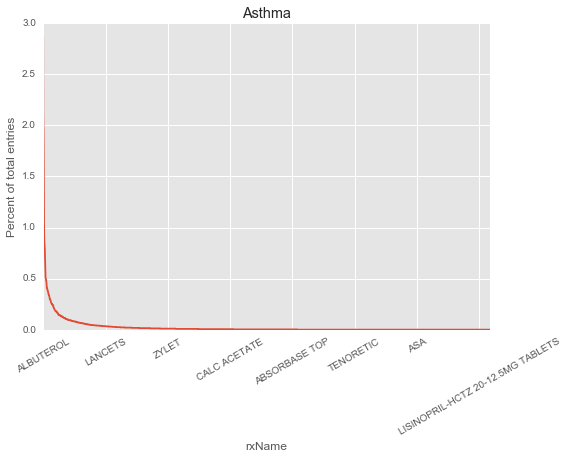

In [54]:
rxname_count_asthma.sort_values(by='entry_count', ascending=False).percent.plot(rot=30)
plt.ylabel('Percent of total entries')
plt.title('Asthma')

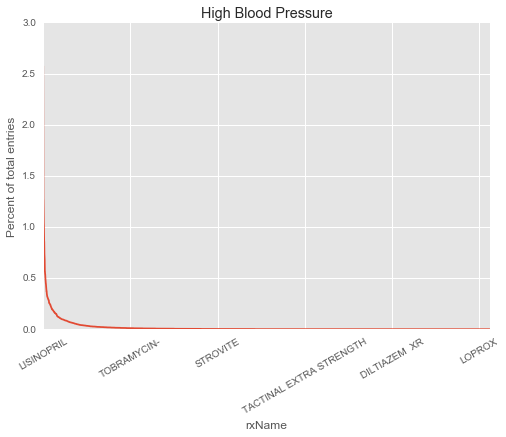

In [55]:
rxname_count_highbp.sort_values(by='entry_count', ascending=False).percent.plot(rot=30)
plt.ylabel('Percent of total entries')
plt.title('High Blood Pressure')

In [56]:
top_rxnames[0:3]

['HUMULIN N', 'PREDNISONE', 'LIPITOR']

<h2>Preparing the data</h2>

We want to take as input the medications prescribed and give as output what diseases a patient has.  We must demonstrate that the end user should be confident in the result.

This is a multi-output classification problem, since patients may have more than one disease.  We can approach this as a set of binary classification problems where we implement a one-vs-all strategy, or we can choose a model that does not require a problem transformation, such as a decision tree, random forest, or kNN.

- First take the top 30 medications for Yes in all the categories
- Keep all the different classes for diagnoses
- Make a decision tree!

- Something like PCA to reduce dimensionality?

In [159]:
top_rxnames = get_top_rxnames(merged_yes, top_n=30, print_stats=False)

In [176]:
meds_input = meds_copy.copy(deep=True)

In [177]:
meds_input = meds_input[meds_input.rxName.isin(top_rxnames)]  # Filter for top rxnames and then drop dupes
meds_input = meds_input[['id','rxName']]
meds_input = meds_input.drop_duplicates()

In [178]:
rxname_dummies = pd.get_dummies(meds_input.rxName)  # make rxname classes have binary 1/0 values
meds_input = pd.merge(meds_input[['id']], rxname_dummies, left_index=True, right_index=True)

In [182]:
output = base_data.copy(deep=True)
diagnoses = [i for i in output.columns if 'Diagnosed' in i]
diagnoses_cols = ['id'] + diagnoses

In [183]:
output = output[diagnoses_cols]

In [185]:
list(output.chdDiagnosed.unique())

['No', 'Inapplicable', 'Yes', 'DK', 'not ascertained', 'Refused']

<h3>Decision tree with 74 binary features and one output: highBPDiagnosed</h3>

In [259]:
from sklearn import tree
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import precision_recall_fscore_support


def match_input_output(meds_input, output, output_list=[]):
    """Return medication data with 1/0 diagnosis flags for each patient."""
    
    if not len(output_list):
        output_list = [i for i in output.columns if 'Diagnosed' in i]
        
    output_cols = ['id'] + output_list
    
    # Merge medication data with diagnosis data on patient id.
    all_data = pd.merge(meds_input, output[output_cols], on='id', how='outer')
    all_data = all_data.fillna(0)
    
    # Consolidate all patient medication info into one row per ['id', outputs].
    grouped_data = all_data.groupby(output_cols, as_index=False).sum()
    return grouped_data


def make_output_binary(data_df):
    """Turn any diagnosis that is not a Yes or No into the most common value."""
    
    df = data_df.copy(deep=True)
    diagnoses = [i for i in df.columns if 'Diagnosed' in i]
    
    # Iterate over every disease column.
    for diagnosis in diagnoses:
        
        all_labels = list(output[diagnosis].unique())
        binary_labels = ['Yes', 'No']
        non_binary_labels = [i for i in all_labels if i not in binary_labels]
        
        # Obtaining the label mode
        binary_labeled = df[df[diagnosis].isin(binary_labels)]
        diagnosis_mode = binary_labeled[diagnosis].mode()[0]
        
        # Replacing non binary labels with the mode.
        for class_label in non_binary:
            df[diagnosis] = df[diagnosis].replace(class_label, diagnosis_mode)
                    
    df = df.replace('Yes', 1)
    df = df.replace('No', 0)
    
    return df


def make_x_and_y(all_outputs_data):
    """Pull out X (meds) and Y (diagnoses) arrays."""
    y_cols = [i for i in all_outputs_data.columns if 'Diagnosed' in i]
    x_cols = [i for i in all_outputs_data.columns if i not in y_cols and i != 'id']
    X = all_outputs_data[x_cols]
    Y = all_outputs_data[y_cols]
    
    return X, Y


def fit_tree(X, Y, test_size=0.2, random_state=137):
    """Fit a decision tree with a holdout test group of fraction test_size."""
    
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=test_size, random_state=random_state
    )

    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, Y_train)

    print 'Num features: {}\nNum outputs: {}\nNum classes: {}'.format(clf.n_features_, clf.n_outputs_, clf.n_classes_)
    print 'Train set accuracy: {:.3}'.format(clf.score(X_train, Y_train))
    print 'Test set accuracy: {:.3}'.format(clf.score(X_test, Y_test))
    print 'Classes: {}'.format(list(clf.classes_))
    
    return clf

In [244]:
binary_output = make_output_binary(output)

In [261]:
bp_data = match_input_output(meds_input, output, output_list=['highBPDiagnosed'])

In [249]:
len(bp_data.id.unique()), len(bp_data)

(61489, 61489)

Accuracy not great even on training set with only one output (67%).  As expected, somewhat lower accuracy for holdout/test set (60%).

In [250]:
x_cols = [i for i in bp_data.columns if i != 'id' and i != 'highBPDiagnosed']
X = bp_data[x_cols]
Y = bp_data[['highBPDiagnosed']]
clf = fit_tree(X, Y, test_size=0.2, random_state=223)

Num features: 74
Num outputs: 1
Num classes: 6
Train set accuracy: 0.674
Test set accuracy: 0.604
Classes: ['DK', 'Inapplicable', 'No', 'Refused', 'Yes', 'not ascertained']


Let's try only using the Yes and No data and fill in the other labels with the mode

In [205]:
x_cols = [i for i in bp_data.columns if i != 'id' and i != 'highBPDiagnosed']

# Turn all non Yes and No things into mode
diagnosis_mode = bp_data[bp_data.highBPDiagnosed.isin(('Yes', 'No'))].highBPDiagnosed.mode()[0]
diagnosis_classes = list(bp_data.highBPDiagnosed.unique())
non_binary = [i for i in diagnosis_classes if i not in ('Yes', 'No')]
bp_binary = bp_data.copy(deep=True)

for class_label in non_binary:
    bp_binary = bp_binary.replace(class_label, diagnosis_mode)

X = bp_binary[x_cols]
Y = bp_binary[['highBPDiagnosed']]
clf_bp = fit_tree(X, Y, test_size=0.2, random_state=211)

Num features: 74
Num outputs: 1
Num classes: 2
Train set accuracy: 0.919
Test set accuracy: 0.862
Classes: ['No', 'Yes']


Accuracy is a lot higher now: 92% for training and 87% for testing.  But we are assuming the non-binary decisions are the same as the mode, for simplicity.  Based on the support, which shows the class breakdown for the true labels, the classes are fairly balanced.

Below, we see that precision is pretty good for both Nos and Yeses (88% and 78% respectively) but low recall for Yeses (52%).

In [206]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=211
)
Y_test_predict = clf_bp.predict(X_test)

# By default returns label stats in alphabetical order of labels.
precision, recall, fscore, support = precision_recall_fscore_support(Y_test, Y_test_predict) 
classes = sorted(list(clf_bp.classes_))

print 'Classes: {}'.format(classes)
print 'Precision: {}\nRecall: {}\nFscore: {}\nSupport: {}'.format(precision, recall, fscore, support)

Classes: ['No', 'Yes']
Precision: [ 0.87522604  0.78224456]
Recall: [ 0.95931567  0.51659292]
Fscore: [ 0.91534365  0.62225183]
Support: [9586 2712]


In [252]:
Y_predict = clf.predict(X_test)

In [254]:
sorted(set(Y_predict))  # It didn't predict any Refused or not ascertained, 
                        # probably because they are so rare.

['DK', 'Inapplicable', 'No', 'Yes']

In [291]:
sorted(list(Y_test.highBPDiagnosed.unique())), set(Y_predict)

(['DK', 'Inapplicable', 'No', 'Yes'], {'Inapplicable', 'No', 'Yes'})

In [249]:
Y_test_arr = np.array(Y_test.highBPDiagnosed)

In [250]:
precision_recall_fscore_support(Y_test_arr, Y_predict)  # Classes in alphabetical order

(array([ 0.        ,  0.61239731,  0.5526884 ,  0.80612846]),
 array([ 0.        ,  0.22355507,  0.87191279,  0.49745455]),
 array([ 0.        ,  0.32754144,  0.67653473,  0.61524623]),
 array([   9, 3668, 5871, 2750]))

In [200]:
Y_probs = clf.predict_proba(X)

<h2>Decision tree multi-output model</h2>

A logistic regression, the usual easy to interpret and quick to run model for classifications, won't work because here because we have a multi-label problem rather than a multi-class problem.  In this case, a patient can have multiple diagnoses.  Decision trees are a model that can handle categorical variables, multiple labels per sample, and can also compute human-interpretable feature importances.  Making label decisions by splitting on features is easy to understand, unlike a neural net.  Decisions trees don't perform well with unbalanced classes, but our classes are fairly balanced.

In [282]:
all_outputs_data = match_input_output(meds_input, output, output_list=[])
all_outputs_data = make_output_binary(all_outputs_data)
# Sweet there are no conflicting diagnoses
len(all_outputs_data.id.unique()), len(all_outputs_data)

(61489, 61489)

In [268]:
X, Y = make_x_and_y(all_outputs_data)

Not bad, training set 83% accuracy, Test 71% accuracy.  The score function for the decision tree is strict and requires that *all* labels are correct for a given entry in order for it to be counted as correct.  

Stats are pretty stable over a few different random seeds for breaking up train and test sets.  An 80/20 split for train/test is used.

In [276]:
clf_all = fit_tree(X, Y, test_size=0.2, random_state=13)

Num features: 74
Num outputs: 10
Num classes: [2 2 2 2 2 2 2 2 2 2]
Train set accuracy: 0.831
Test set accuracy: 0.706
Classes: [array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1])]


In [278]:
clf_all = fit_tree(X, Y, test_size=0.2, random_state=9)

Num features: 74
Num outputs: 10
Num classes: [2 2 2 2 2 2 2 2 2 2]
Train set accuracy: 0.832
Test set accuracy: 0.703
Classes: [array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1])]


In [280]:
clf_all = fit_tree(X, Y, test_size=0.2, random_state=77)

Num features: 74
Num outputs: 10
Num classes: [2 2 2 2 2 2 2 2 2 2]
Train set accuracy: 0.832
Test set accuracy: 0.702
Classes: [array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1])]


Index([u'ACETAMINOPHEN-HYDROCODONE BITARTRATE', u'ACTOS', u'ADVAIR DISKU',
       u'ADVAIR DISKUS', u'ALBUTEROL', u'ALBUTEROL SULFATE', u'ALPRAZOLAM',
       u'AMLODIPINE', u'AMLODIPINE BESYLATE', u'AMOXICILLIN',
       u'APAP-HYDROCODONE BITARTRATE', u'ASPIRIN', u'ATENOLOL',
       u'AZITHROMYCIN', u'BAYER CONTOR', u'CARVEDILOL', u'COMBIVENT', u'COREG',
       u'CRESTOR', u'DIGOXIN', u'DIOVAN', u'FLOVENT HFA', u'FUROSEMIDE',
       u'GABAPENTIN', u'GLIMEPIRIDE', u'GLIPIZIDE', u'GLYBURIDE', u'HUMULIN N',
       u'HYDROCHLOROT', u'HYDROCHLOROTHIAZIDE', u'HYDROCO-APAP', u'IBUPROFEN',
       u'INSULIN SYRG', u'LANTUS', u'LASIX', u'LEVAQUIN', u'LEVOTHYROXIN',
       u'LEVOTHYROXINE SODIUM', u'LIPITOR', u'LISINOPRIL', u'LORATADINE',
       u'LOVASTATIN', u'METFORMIN', u'METOPROL TAR', u'METOPROLOL',
       u'METOPROLOL TART', u'METOPROLOL TARTRATE', u'NAPROXEN', u'NASONEX',
       u'NEXIUM', u'NITROGLYCERIN', u'NOVOLIN N', u'OMEPRAZOLE', u'ONETOUCH',
       u'PLAVIX', u'POTASSIUM CHLORIDE',

In [291]:
feature_importances = pd.DataFrame(zip(list(X.columns), list(clf_all.feature_importances_)),
             columns=['feature', 'importance'])

Looking at feature importances (Gini importance) below.  Larger importances mean a feature has better ability to distinguish between labels accurately.  Metformin has the highest importance, probably because it dominated in the diabetes Yes diagnoses, and to a larger extent than any of the other diagnoses' top medications.  Lisinopril was present in many of the top 10 medications but was farther down in asthma in particular.  Furosemide and Albuterol both dominated only in one diagnosis each, so would also be useful for selecting one particular disease.

In [295]:
feature_importances.sort_values(by='importance', ascending=False)[0:20]  

,feature,importance
42,METFORMIN,0.113212
39,LISINOPRIL,0.078883
22,FUROSEMIDE,0.041276
4,ALBUTEROL,0.030876
29,HYDROCHLOROTHIAZIDE,0.030574
54,PLAVIX,0.030316
7,AMLODIPINE,0.024966
12,ATENOLOL,0.023541
61,SIMVASTATIN,0.022837
13,AZITHROMYCIN,0.021648


Below, we still see name variations in these top medication names.  Going further we could try mitigating this with Multiple Correspondance Analysis, the equivalent of a PCA for categorical features.  This would group together correlated variables into new feature eigenvectors.

In [283]:
X.columns

Index([u'ACETAMINOPHEN-HYDROCODONE BITARTRATE', u'ACTOS', u'ADVAIR DISKU',
       u'ADVAIR DISKUS', u'ALBUTEROL', u'ALBUTEROL SULFATE', u'ALPRAZOLAM',
       u'AMLODIPINE', u'AMLODIPINE BESYLATE', u'AMOXICILLIN',
       u'APAP-HYDROCODONE BITARTRATE', u'ASPIRIN', u'ATENOLOL',
       u'AZITHROMYCIN', u'BAYER CONTOR', u'CARVEDILOL', u'COMBIVENT', u'COREG',
       u'CRESTOR', u'DIGOXIN', u'DIOVAN', u'FLOVENT HFA', u'FUROSEMIDE',
       u'GABAPENTIN', u'GLIMEPIRIDE', u'GLIPIZIDE', u'GLYBURIDE', u'HUMULIN N',
       u'HYDROCHLOROT', u'HYDROCHLOROTHIAZIDE', u'HYDROCO-APAP', u'IBUPROFEN',
       u'INSULIN SYRG', u'LANTUS', u'LASIX', u'LEVAQUIN', u'LEVOTHYROXIN',
       u'LEVOTHYROXINE SODIUM', u'LIPITOR', u'LISINOPRIL', u'LORATADINE',
       u'LOVASTATIN', u'METFORMIN', u'METOPROL TAR', u'METOPROLOL',
       u'METOPROLOL TART', u'METOPROLOL TARTRATE', u'NAPROXEN', u'NASONEX',
       u'NEXIUM', u'NITROGLYCERIN', u'NOVOLIN N', u'OMEPRAZOLE', u'ONETOUCH',
       u'PLAVIX', u'POTASSIUM CHLORIDE',

In [296]:
# Scoring seems to work when it's done in the method, but not afterwards?
# Accuracy metric is quite strict in multilabel; requires all sets of labels to be predicted correctly.  
# If an entry has two labels and you only predict one correctly, that's counted as wrong!

In [297]:
# Defaults for multilabel_classification:
# make_multilabel_classification(n_samples=100, n_features=20, n_classes=5, n_labels=2, length=50, 
# allow_unlabeled=True, sparse=False, return_indicator='dense', return_distributions=False, random_state=None)

<h2>Random plot explorations</h2>

In [60]:
chd_dummies = pd.get_dummies(base_copy.chdDiagnosed, prefix='chdDiagnosed')
sns_test = pd.merge(chd_dummies, base_copy[['id', 'panel', 'pooledWeight', 'age']], left_index=True, right_index=True)

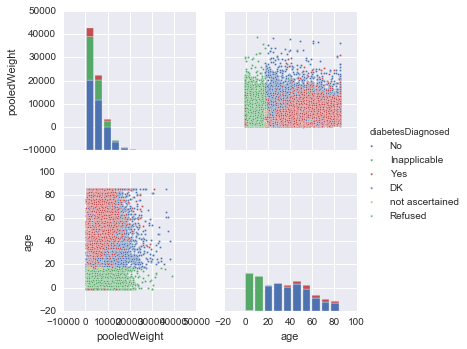

In [59]:
# Pairplot works well for looking at correlations between continuous variables
# Can also color the scatter plots with a categorical variable
sns.set()

df = base_copy[['pooledWeight', 'age', 'diabetesDiagnosed']]
sns.pairplot(df, hue='diabetesDiagnosed', markers='.')

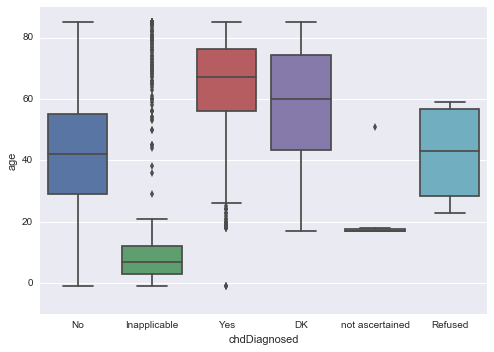

In [62]:
sns.boxplot(x='chdDiagnosed', y='age', data=base_copy)